# Hotel Dataset Digital Humanities Project

**Xiaorui Liu** Digital Humanities 101

### Topic Overview ###

Reviews are difficult to interpret. Innately there are subjective ratings towards things that can be variable. Everyone has different expectations, and reviews reflect this sentiment. In this project I look at a dataset about hotel reviews, found on Kaggle provided by Datafiniti's Business Database. To quote the description on Kaggle "This is a list of 1,000 hotels and their reviews... The dataset includes hotel location, name, rating, review data, title, username, and more." 

In this project I use the data to:

1. Do some general data exploration surrounding the ratings, common words, etc. 

2. Perform topic modeling to see if there are any notable topics that show up, do hotel reviewers have topics that they focus on?
    
3. Create and train a classifier to see it's success - with something as variable as reviews will it be able to classify well?
    

First, let's import the packages that are required for running the code.

In [2]:
import pandas as pd
import seaborn as sns   
import spacy
import nltk
import geopandas as gpd
import numpy as np 
from sklearn.utils import shuffle
from shapely.geometry import Point
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from nltk.stem import WordNetLemmatizer
from spacy.language  import Language
from spacy_langdetect import LanguageDetector
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from collections import Counter
import pyLDAvis.sklearn
from gensim.models.phrases import Phrases, Phraser
from wordcloud import WordCloud
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression

Now, lets read the dataset in the form of a csv file and take a look at what information we are given.

In [3]:
reviews = pd.read_csv("hotel_reviews.csv")

# How many entries are there in this dataset?
print("The amount of entries are: " + str(len(reviews)))

# Looking at the first few entries
reviews.head()

The amount of entries are: 35912


,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


##### Initial Observations
We can see that there is a lot of information contained in each entry. Since we are specifically interested in the ratings and their relation to the reviews, we can either look at the titles of the reviews or the text. For this project I chose to look at the text because it would simply offer more information for the algorithms to analyze and thus create a more comprehensive analysis, as the titles are not long.

Let's use the longitude and latitude values to plot the location of all the hotels on a map to see what we are dealing with.

/Users/xiaorui/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/xiaorui/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/xiaorui/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/xiaorui/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:>

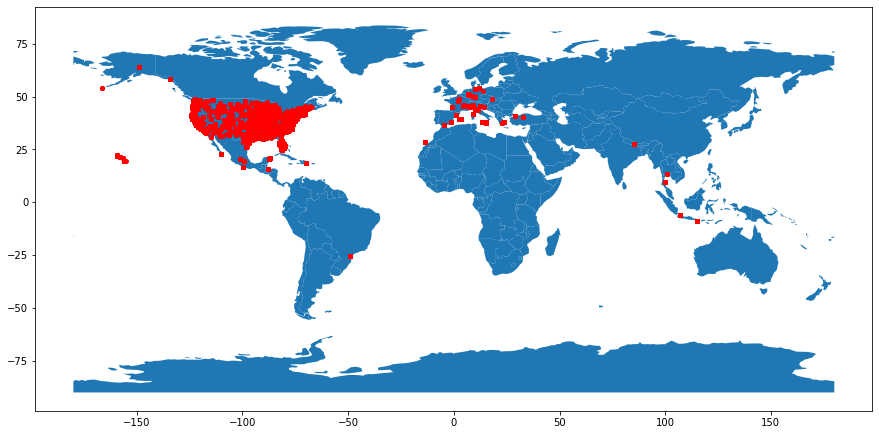

In [4]:
geometry = [Point(xy) for xy in zip(reviews["longitude"], reviews['latitude'])]
gdf = GeoDataFrame(reviews, geometry = geometry)


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax = world.plot(figsize = (15, 15)), marker = 'o', color = 'red', markersize = 15)

You can see that there are reviews for hotels in many different countries other than America. This might complicate the analysis as it explains why some of the reviews are not in English, which means that I have to further filter the data by finding only the English entries.

For further data analysis, I will change the column names to be more straightforward and easier to manipulate.

In [5]:
reviews = reviews.rename(columns = {'reviews.date' : 'date', 'reviews.dateAdded' : 'dateAdded', 'reviews.doRecommend' : 'doRecommend', 'reviews.id' : 'id', 'reviews.rating' : 'rating', 
'reviews.rating' : 'rating', 'reviews.text' : 'text', 'reviews.title' : 'title', 'reviews.userCity' : 'userCity', 'reviews.username' : 'username', 'reviews.userProvince' : 'userProvince' })
reviews

,address,categories,city,country,latitude,longitude,name,postalCode,province,date,dateAdded,doRecommend,id,rating,text,title,userCity,username,userProvince,geometry
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN,POINT (12.37619 45.42161)
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN,POINT (12.37619 45.42161)
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN,POINT (12.37619 45.42161)
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN,POINT (12.37619 45.42161)
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN,POINT (12.37619 45.42161)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35907,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,2012-03-20T00:00:00Z,2016-06-23T16:50:58Z,NaN,NaN,5.0,Best of the Best!!!! My family and I stayed in...,Amazing time (both times!!),Charlotte,Chelsa K.,NC,POINT (-83.45730 35.75487)
35908,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,2012-03-12T00:00:00Z,2016-06-23T16:50:58Z,NaN,NaN,5.0,Amazing Vacation in Beautiful Cabin We stayed ...,Amazing time (both times!!),Charlotte,Heather D.,NC,POINT (-83.45730 35.75487)
35909,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,2015-11-03T00:00:00Z,2016-06-23T16:50:58Z,NaN,NaN,5.0,My husband and I stayed at Tree Tops which is ...,Amazing time (both times!!),Charlotte,Carol W.,NC,POINT (-83.45730 35.75487)
35910,3747 29th St S E,"Hotels-Apartment,Corporate Lodging,Hotels,Lodging",Grand Rapids,US,42.909480,-85.573590,Extended Stay America Grand Rapids - Kentwood,49512,MI,NaN,2015-12-01T19:40:54Z,NaN,NaN,0.0,to share your opinion of this businesswith YP ...,NaN,NaN,write a review,NaN,POINT (-85.57359 42.90948)


Let's look at the distribution of the ratings to see what we could possibly do with the information. Are they on the same scale, that would make things easier for us to process.

5.0     12671
4.0      9755
3.0      5708
1.0      3068
2.0      2979
0.0       337
10.0      101
9.6        53
9.2        49
4.3        26
4.8        25
8.3        25
8.8        24
7.5        24
7.9        24
4.2        22
3.4        17
6.3        14
4.1        14
4.5        13
7.1        13
6.7        12
5.4         9
4.6         7
3.1         7
3.3         6
4.7         6
4.4         6
4.9         6
5.8         6
2.4         4
3.8         3
2.5         3
3.9         2
3.2         2
3.7         2
7.0         1
6.0         1
2.9         1
2.8         1
1.5         1
1.3         1
9.5         1
Name: rating, dtype: int64


<AxesSubplot:ylabel='Frequency'>

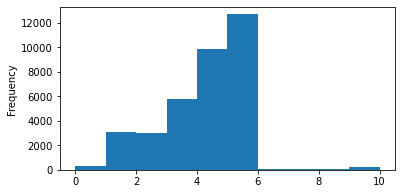

In [6]:
print(reviews['rating'].value_counts())
reviews["rating"].plot(kind = 'hist', bins = 10, figsize = (6,3))

Simply looking at the distribution you can see that they are rated on two scales. One is simply a 0 - 5 scale that only involves whole numbers, which make up the majority of the dataset. The second rating system is a rating system from 0 - 10, which allows decimal values. When training the classifier we will need to make a decision about what information to cut and which to keep to analyze. Right now, I will reduce the information to the 0 - 5 scale. This is for two reasons. The first being the values captured 0 - 5 scale represent the bulk of the data, thus cutting out the 0 - 10 scale will not largely harm the amount of text being fed to the algorithms. The second is for intepretation sake. One could imagine that a 5 on the 0 - 5 scale as the best rating while a 5 on the 0 - 10 scale is an average score. Parsing out this data allows for there to be a more accurate assessment between the relationship between the review and the rating. Additionally, I noticed that many of the values for the rating 0 have nonsensical/non-important reviews, so I will also be removing those. On a different note, it is nice to see that there are more positive reviews then negative ones.

In [7]:
reviews = reviews.dropna(subset = ["text"])
reviews = reviews[reviews['rating'] != 0.0]

Now that the 0 and NaN values are dropped, we will focus on the topic modeling so that we can just get a general idea of any topics that form in many reviews. To do that, we will have to preprocess the text column so that the algorithm can process the text. First, we will remove all the ratings that are not in English using spacy's language detector. It is important to note that this process reads a string and returrns a language with a degree of certainty. That means that there may be a chance for certain rows to be erroneously deleted (or for non-English entries to slip through), however this is the easiest way to filter out non-English entries. 

In [8]:
def get_lang_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load("en_core_web_sm")
Language.factory("language", func=get_lang_detector)
nlp.add_pipe('language', last=True)

def get_lang(string):
    dict = nlp(string)
    return dict._.language["language"]

reviews["language"] = [get_lang(x) for x in reviews['text']]
reviews.drop(reviews[reviews['language'] != 'en'].index, inplace = True)

Now we can process the text, since there are only english entries left. We will use gensim to perform a simple preprocess, remove stop words, and lemmatize the text.

In [9]:
reviews["textProcessed"] = reviews["text"].apply(gensim.utils.simple_preprocess)
processed = reviews["textProcessed"]
stop_words = stopwords.words('english')
new = ['would', 'could', 'got', 'get']
stop_words.extend(new)
no_stop = processed.apply(lambda x: [w for w in x if w not in stop_words])
lemmatizer = WordNetLemmatizer()

def lemmatize(list):
    return " ".join([lemmatizer.lemmatize(w) for w in list if w  ])

reviews["textProcessed"] = [lemmatize(list) for list in no_stop]


Now we can take a look at the most frequent words in our reviews since we processed our words.

           Word  Frequency
0          room      26345
1         hotel      19391
2          stay      11146
3         staff      10180
4         great       9803
5         clean       9735
6     breakfast       8629
7          nice       8158
8          good       7285
9         night       6014
10          bed       5927
11     friendly       5640
12        place       5144
13          one       4918
14  comfortable       4895


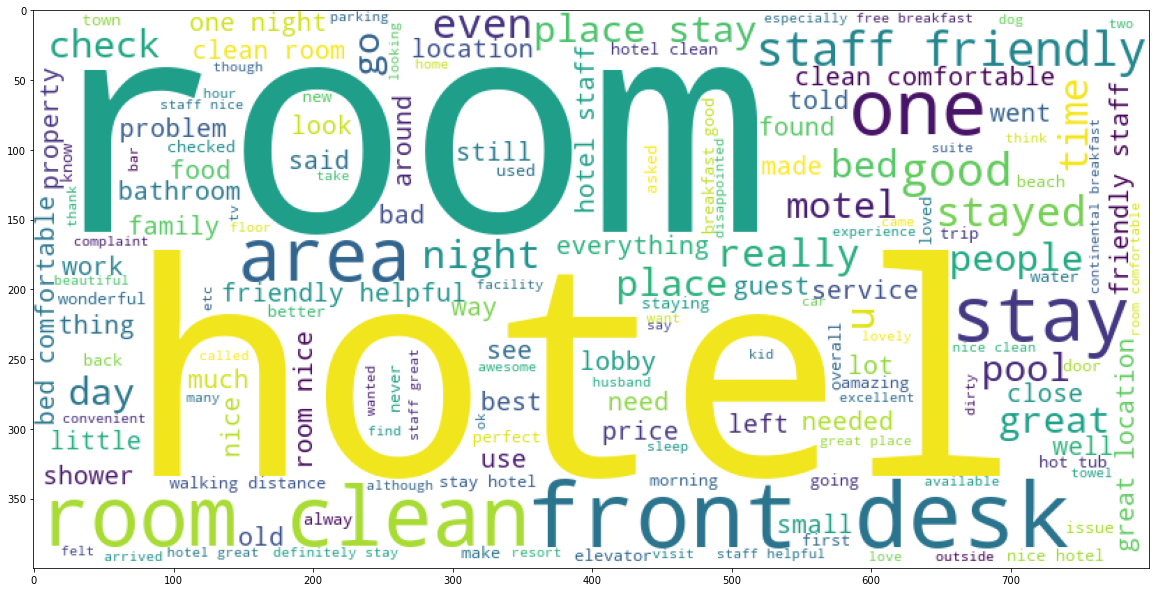

In [10]:
hr_str = ' '.join(reviews['textProcessed'].tolist())
hr_tok = hr_str.split()
hr_freq = Counter(hr_tok)

# Print the 10 most common words
hr_df = pd.DataFrame(hr_freq.most_common(15), columns = ["Word", "Frequency"])
print(hr_df)

# Build a wordcloud of of the most common words
plt.figure(figsize = (20,20))
wordCloud = WordCloud(max_words = 200, min_font_size = 10, height = 400, width = 800, background_color = "white").generate(' '.join(reviews['textProcessed']))

plt.imshow(wordCloud)

Looking at the word cloud there are a couple of things that can be noticed immediately. Obviously some of the most frequent words are "hotel", "room", and "staff", but looking at the distribution/amount of positively connotative words like "great, "clean", and "friendly" versus the negative ones like "never" and "dirty" seem to be proportional to our findings with the ratings. 

#### Topic Modeling 

Since our data is processed, now we can conduct the topic modeling using gensim. 

In [13]:
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel

lemmas = [t.split() for t in reviews["textProcessed"]]
# Create Dictionary - like "fit" using sklearn
dictionary = corpora.Dictionary(lemmas)

# filter extremes and assign new ids
dictionary.filter_extremes(no_above=0.9)
dictionary.compactify() 

# Create Document-Term Matrix of our whole corpus (like "transform" using sklearn) 
corpus = [dictionary.doc2bow(text) for text in lemmas]


In [17]:
from gensim.models.ldamodel import LdaModel

lda_gensim = LdaModel(corpus=corpus,   # stream of document vectors or sparse matrix of shape
            id2word=dictionary,       # mapping from word IDs to words (for determining vocab size)
            num_topics= 10,            # amount of topics
            random_state=42,         # seed to generate random state; useful for reproducibility
            passes=25,                 # amount of iterations/epochs 
            per_word_topics=False)    # computing most-likely topics for each word

In [18]:
import pyLDAvis.gensim_models as gensimvis

panel = gensimvis.prepare(lda_gensim, corpus, dictionary, mds="tnse")

pyLDAvis.display(panel)

/Users/xiaorui/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/xiaorui/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/xiaorui/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/xiaorui/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/xiaorui/opt/anaconda3/lib/

The topic model has interesting findings. While not all of the topics are perfectly formed, there are a few topics that are very specific. The topic models will vary with each run. However, even after multiple runs, I found some topics were consistent. Some examples of topics are there's always one concerning location (listing various locations that are near the hotel), one about breakfasts and food, and a couple that are more related to the service. These include the service that the front desk provides and some about how the hotel is, usually divided into positive and negative descriptions in two topics.

#### Review Classifier

Now that we have a sense of the topics that the reviews have, we can move on to the review classifier. Like I said before we have to classify the data in some way, so in this example all the ratings that are above 3 are considered positive (represented by a 1), while those 3 and under are considered negative (represented by a 0).

In [12]:
viable = [1.0, 2.0, 3.0, 4.0, 5.0]
def rating_filter(num):
    if num not in viable:
        return -1
    elif num > 3.0:
        return 1
    else: 
        return 0

reviews["sentiment"] = reviews["rating"].apply(rating_filter)

Now let's remove all the entries that have a '-1', or delete, tag on them.

In [14]:
reviews = reviews.loc[reviews["sentiment"] != -1]

Now we can shuffle and randomize the data to remove possible bias.

In [15]:
x, y = shuffle(np.array(reviews.textProcessed), np.array(reviews.sentiment), random_state = 1)

Now we can use the TfidVectorizer to perform a logistic regression on our training data, and then test it with our test data!

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y)
vectorizer = TfidfVectorizer(min_df=5,stop_words = "english")
vectorizer.fit(x)
x_train = vectorizer.transform(x_train)
x_test = vectorizer.transform(x_test)

feature_names = vectorizer.get_feature_names_out()
logit_class = LogisticRegression(random_state = 0, penalty = "l2", C = 1000, max_iter=34000)
model = logit_class.fit(x_train, y_train)

model.score(x_test, y_test)

0.7660847880299252

We can see that the success of our trained classifer on the test data is around 75%, which isn't great but also isn't bad considering how reviews have so many levels of variability attached to them. I personally was expecting a lot less, especially since this data is not the cleanest, and reviews themselves aren't too predictable. Someone with a positive sounding review may still give a low rating, it is all upon the individual. Using our new model we can see which words are most associated with positive and negative reviews!

In [23]:
top25pos = np.argsort(model.coef_[0])[-50:]
print("Top features for positive reviews:")
print(list(feature_names[j] for j in top25pos))
print()
print("Top features for negative reviews:")
top25neg = np.argsort(model.coef_[0])[:50]
print(list(feature_names[j] for j in top25neg))

Top features for positive reviews:
['arc', 'bleed', 'specially', 'hint', 'coronado', 'auto', 'sympathetic', 'pueblo', 'stressed', 'thai', 'amtrak', 'extending', 'dicey', 'skeptical', 'docker', 'eaglecrest', 'kelsey', 'anti', 'furious', 'sewing', 'approachable', 'lug', 'anne', 'deserves', 'doggie', 'kayak', 'ron', 'styled', 'clipping', 'simpson', 'vinyl', 'lip', 'jakarta', 'razor', 'debut', 'verizon', 'spotlessly', 'parkway', 'pittsburgh', 'bet', 'negotiate', 'grown', 'kindness', 'snowboarding', 'ham', 'catered', 'professionalism', 'benedict', 'bumped', 'soundproof']

Top features for negative reviews:
['thanked', 'beetle', 'busted', 'cc', 'overhaul', 'deserted', 'contract', 'claiming', 'lighthouse', 'role', 'pig', 'raw', 'sweeping', 'sicily', 'housing', 'unwelcoming', 'pill', 'destroyed', 'toe', 'procedure', 'stunk', 'corporation', 'frankly', 'dreary', 'prob', 'wrapper', 'bean', 'barbecue', 'explanation', 'meadow', 'george', 'bolted', 'involved', 'cemetery', 'signature', 'pest', 'enemy

These results are rather surprising. I was personally expecting a lot more straightforward words for both catagories, like "good" and "bad", but from a intuitive perspective some of these make sense. Obviously the words with positive connotations aren't too surprising to see in the positive reviews section, like "kindness" and "professionalism", however there other peculiar words that can be further looked at. For example "kayak" and "snowboarding" are both in the positive review's features. A possible explaination for this could be these activites are often associated with fun vactions, maybe even resorts. It wouldn't be a stretch to assume that these people had good time on their trip doing these activities and thus rated the hotel highly. Additionally, it could interesting to see if money is correlated with rating on hotels, as people who have more money to spend on vacations probably are happier in general. Similar analysis could be done on the negative reviews. "Pest" and "dreary" are rather intuitive to understand, however "cemetery" seems a little random. Maybe the hotel was near a cemetary and thus was booked a lot for funerals, which may be lead to lower morale and lower reviews. Mabe it was next to a cemetery and gave off creepy vibes. These questions show the limitations of these methods, it would probably be a good idea to look at the specific reviews and see the context that cemetery was used in.

Using this model we can now predict new reviews that the user can input. Change the new_review string to see what it classifies as! Remember that 1 means that it is positive while 0 means it is negative.

In [28]:
new_review = "This hotel was by the beach. It was dirty and sad to stay at."

tfidf_rev = vectorizer.transform([new_review])

model.predict(tfidf_rev)

array([0])